In [44]:
import warnings
warnings.filterwarnings("ignore")
import torch
import os
from going_modular.model.TripletFaceRecognition import EmbeddingNetConcatV3, TripletNetConcatV3
from going_modular.dataloader.triplet import CustomExrDatasetConCatV3
from torch.utils.data import DataLoader
import csv
import json
from mtcnn import MTCNN
import cv2
import numpy as np
import albumentations as A
import random
import shutil
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Đặt seed toàn cục
seed = 42
torch.manual_seed(seed)

CONFIGURATION = {
    # Thư mục
    'data_dir': './Gallery',
    'checkpoint': './checkpoint/new/concat_3/models/checkpoint.pth',
    'recognition_dir': './Gallery/recognition',

    # Cấu embedding
    'embedding_size': 512,
    'batch_size': 16,
    
    # Cấu hình khác
    'image_size': 256
}

## Import images to gallery

In [49]:
gallery_dir = './Gallery'
recognition_dir = './Gallery/recognition'

gallery_albedo_dir = os.path.join(gallery_dir, 'Albedo', 'test')
gallery_normalmap_dir = os.path.join(gallery_dir, 'Normal_Map', 'test')
gallery_depthmap_dir = os.path.join(gallery_dir, 'Depth_Map', 'test')

recognition_albedo_dir = os.path.join(recognition_dir, 'Albedo', 'test')
recognition_normalmap_dir = os.path.join(recognition_dir, 'Normal_Map', 'test')
recognition_depthmap_dir = os.path.join(recognition_dir, 'Depth_Map', 'test')

os.makedirs(recognition_dir, exist_ok=True)
os.makedirs(recognition_albedo_dir, exist_ok=True)
os.makedirs(recognition_normalmap_dir, exist_ok=True)
os.makedirs(recognition_depthmap_dir, exist_ok=True)

albedo_folder = './3D_Dataset/Albedo'
depthmap_folder = './3D_Dataset/Depth_Map'
normalmap_folder = './3D_Dataset/Normal_Map'
id = '1050'

# Hàm resize ảnh
def process_image(src_path, dst_path, target_size=256):
    # Đọc ảnh từ file nguồn
    image = cv2.imread(src_path, cv2.IMREAD_UNCHANGED)
    if image is None:
        print(f"Lỗi: Không thể đọc ảnh {src_path}")
        return
    
    # Resize ảnh về kích thước target_size x target_size
    resized_image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
    
    # Ghi ảnh đã resize vào file đích
    cv2.imwrite(dst_path, resized_image)

def copy_to_new_dir(image_id):
    gallery_albedo_id_dir = os.path.join(gallery_albedo_dir, image_id)
    gallery_normalmap_id_dir = os.path.join(gallery_normalmap_dir, image_id)
    gallery_depthmap_id_dir = os.path.join(gallery_depthmap_dir, image_id)
    
    recognition_albedo_id_dir = os.path.join(recognition_albedo_dir, image_id)
    recognition_normalmap_id_dir = os.path.join(recognition_normalmap_dir, image_id)
    recognition_depthmap_id_dir = os.path.join(recognition_depthmap_dir, image_id)
    
    # Tạo thư mục đích nếu chưa tồn tại
    os.makedirs(gallery_albedo_id_dir, exist_ok=True)
    os.makedirs(gallery_normalmap_id_dir, exist_ok=True)
    os.makedirs(gallery_depthmap_id_dir, exist_ok=True)
    
    os.makedirs(recognition_albedo_id_dir, exist_ok=True)
    os.makedirs(recognition_normalmap_id_dir, exist_ok=True)
    os.makedirs(recognition_depthmap_id_dir, exist_ok=True)
    
    # Kiểm tra số lượng ảnh trong thư mục trước khi sử dụng random.sample
    albedo_images = os.listdir(os.path.join(albedo_folder, image_id))
    normalmap_images = os.listdir(os.path.join(normalmap_folder, image_id))
    depthmap_images = os.listdir(os.path.join(depthmap_folder, image_id))
    
    if len(albedo_images) < 2 or len(normalmap_images) < 2 or len(depthmap_images) < 2:
        print(f"Lỗi: Thiếu ảnh trong thư mục {image_id}")
        return
    
    select_name_path = random.sample(albedo_images, 2)
    
    # Copy và resize ảnh từ từng thư gallery và recognition_dir
    select_name_path = random.sample(os.listdir(os.path.join(albedo_folder, id)), 2)
    
    src_albedo = os.path.join(albedo_folder, id, select_name_path[0])
    dst_albedo = os.path.join(gallery_albedo_id_dir, select_name_path[0])
    print(src_albedo)
    print(dst_albedo)
    process_image(src_albedo, dst_albedo)
    
    src_normalmap = os.path.join(normalmap_folder, id, select_name_path[0])
    dst_normalmap = os.path.join(gallery_normalmap_id_dir, select_name_path[0])
    process_image(src_normalmap, dst_normalmap)
        
    src_depthmap = os.path.join(depthmap_folder, id, select_name_path[0])
    dst_depthmap = os.path.join(gallery_depthmap_id_dir, select_name_path[0])
    process_image(src_depthmap, dst_depthmap)
    print(f'gallery: {select_name_path[0]}')
    
    src_albedo = os.path.join(albedo_folder, id, select_name_path[1])
    dst_albedo = os.path.join(recognition_albedo_id_dir, select_name_path[1])
    process_image(src_albedo, dst_albedo)
    
    src_normalmap = os.path.join(normalmap_folder, id, select_name_path[1])
    dst_normalmap = os.path.join(recognition_normalmap_id_dir, select_name_path[1])
    process_image(src_normalmap, dst_normalmap)
        
    src_depthmap = os.path.join(depthmap_folder, id, select_name_path[1])
    dst_depthmap = os.path.join(recognition_depthmap_id_dir, select_name_path[1])
    process_image(src_depthmap, dst_depthmap)
    print(f'recognition: {select_name_path[1]}')
    
    return select_name_path
        
gallery_filename, recognition_filename = copy_to_new_dir(id)

./3D_Dataset/Albedo/1050/2009-09-04_15-24-23.exr
./Gallery/Albedo/test/1050/2009-09-04_15-24-23.exr
gallery: 2009-09-04_15-24-23.exr
recognition: 2009-09-04_15-21-17.exr


In [50]:
# def delete_id_from_dirs(id):
#     # Các thư mục cần xóa
#     gallery_albedo_id_dir = os.path.join(gallery_albedo_dir, id)
#     gallery_normalmap_id_dir = os.path.join(gallery_normalmap_dir, id)
#     gallery_depthmap_id_dir = os.path.join(gallery_depthmap_dir, id)
    
#     recognition_albedo_id_dir = os.path.join(recognition_albedo_dir, id)
#     recognition_normalmap_id_dir = os.path.join(recognition_normalmap_dir, id)
#     recognition_depthmap_id_dir = os.path.join(recognition_depthmap_dir, id)
    
#     # Xóa các thư mục nếu tồn tại
#     for dir_path in [gallery_albedo_id_dir, gallery_normalmap_id_dir, gallery_depthmap_id_dir,
#                      recognition_albedo_id_dir, recognition_normalmap_id_dir, recognition_depthmap_id_dir]:
#         if os.path.exists(dir_path):
#             shutil.rmtree(dir_path)  # Xóa thư mục cùng với tất cả các tệp bên trong
#             print(f"Đã xóa thư mục: {dir_path}")
#         else:
#             print(f"Thư mục không tồn tại: {dir_path}")
# # Xóa thư mục của id đã tạo
# delete_id_from_dirs(id)

In [51]:
# for id in os.listdir(albedo_folder):
#     id_path = os.path.join(albedo_folder, id)
#     if len(os.listdir(id_path)) == 2:
#         print(id)

# Generate embedding to csv file

In [52]:
test_transform = A.Compose([
    A.Resize(height=CONFIGURATION['image_size'], width=CONFIGURATION['image_size'])
], additional_targets={
    'albedo': 'image',
    'depthmap': 'image'
})

embedding_net = EmbeddingNetConcatV3(conf=CONFIGURATION)

model = TripletNetConcatV3(embedding_net).to(device)
checkpoint = torch.load(CONFIGURATION['checkpoint'])
model.load_state_dict(checkpoint['model_state_dict'])

dataset = CustomExrDatasetConCatV3(data_dir=CONFIGURATION['data_dir'], transform=test_transform, train=False)
dataloader = DataLoader(
    dataset, 
    batch_size=CONFIGURATION['batch_size'], 
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

classes = dataset.classes

In [53]:
dataiter = iter(dataloader)
images, label_index = next(dataiter)
label_index

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [54]:
# Chuyển sang chế độ đánh giá
model.eval()

# Lưu embedding và class vào CSV
output_csv = "embeddings_and_classes.csv"
print(f"Lưu dữ liệu vào {output_csv}...")

with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Class", "Embedding"])

    with torch.no_grad():
        for X, label_index in dataloader:
            # Đưa batch lên GPU nếu có
            X = X.to(device)

            # Sinh embedding
            embeddings = model.get_embedding(X).cpu().numpy()  # Chuyển về CPU

            # Lấy nhãn tương ứng
            labels = [classes[i] for i in label_index.numpy()]

            # Lưu vào CSV
            for embedding, label in zip(embeddings, labels):
                embedding_str = json.dumps(embedding.tolist())  # Chuyển thành chuỗi JSON
                writer.writerow([label, embedding_str])

print(f"Lưu thành công dữ liệu vào {output_csv}.")

Lưu dữ liệu vào embeddings_and_classes.csv...
Lưu thành công dữ liệu vào embeddings_and_classes.csv.


# Test face recognition

## Tính AUC, Accuracy

In [55]:
def compute_roc_auc(
    dataloader: torch.utils.data.DataLoader, 
    model: torch.nn.Module, 
    device: str
):
    
    model.eval()
    with torch.no_grad():
        embeddings_list = []
        for batch in dataloader:
            images, ids = batch
            images = images.to(device)
            embeddings = model.get_embedding(images)
            
            embeddings_list.append((ids, embeddings))
        
        # Concatenate all embeddings into one tensor
        all_ids = torch.cat([x[0] for x in embeddings_list], dim=0)
        all_embeddings = torch.cat([x[1] for x in embeddings_list], dim=0)
        
        euclidean_scores = []
        euclidean_labels = []
        cosine_scores = []
        cosine_labels = []

        # Compute pairwise Euclidean distance and cosine similarity
        all_embeddings_norm = all_embeddings / all_embeddings.norm(p=2, dim=1, keepdim=True)
        euclidean_distances = torch.cdist(all_embeddings, all_embeddings, p=2)  # Euclidean distance matrix
        cosine_similarities = torch.mm(all_embeddings_norm, all_embeddings_norm.t())  # Cosine similarity matrix
        
        # Compute labels (same id = 0, different id = 1)
        labels = (all_ids.unsqueeze(1) == all_ids.unsqueeze(0)).int().to(device)

        # Flatten and filter results
        euclidean_scores = euclidean_distances[torch.triu(torch.ones_like(labels), diagonal=1) == 1].cpu().numpy()
        euclidean_labels = labels[torch.triu(torch.ones_like(labels), diagonal=1) == 1].cpu().numpy()
        
        cosine_scores = cosine_similarities[torch.triu(torch.ones_like(labels), diagonal=1) == 1].cpu().numpy()
        cosine_labels = labels[torch.triu(torch.ones_like(labels), diagonal=1) == 1].cpu().numpy()
        
        # Compute ROC AUC for Euclidean distance
        euclidean_true_labels = 1 - np.array(euclidean_labels)
        euclidean_pred_scores = np.array(euclidean_scores)
        fpr_euclidean, tpr_euclidean, thresholds_euclidean = roc_curve(euclidean_true_labels, euclidean_pred_scores)
        roc_auc_euclidean = auc(fpr_euclidean, tpr_euclidean)

        # Compute ROC AUC for Cosine similarity
        cosine_true_labels = np.array(cosine_labels)
        cosine_pred_scores = np.array(cosine_scores)
        fpr_cosine, tpr_cosine, thresholds_cosine = roc_curve(cosine_true_labels, cosine_pred_scores)
        roc_auc_cosine = auc(fpr_cosine, tpr_cosine)
        
        # Calculate accuracy for Euclidean distance
        euclidean_optimal_idx = np.argmax(tpr_euclidean - fpr_euclidean) # Chọn ngưỡng tại điểm có giá trị tpr - fpr lớn nhất trên đường ROC, vì đây là nơi tối ưu hóa sự cân bằng giữa tỷ lệ phát hiện (TPR) và tỷ lệ báo động giả (FPR).
        euclidean_optimal_threshold = thresholds_euclidean[euclidean_optimal_idx]
        euclidean_pred_labels = (euclidean_pred_scores >= euclidean_optimal_threshold).astype(int)
        euclidean_accuracy = accuracy_score(euclidean_true_labels, euclidean_pred_labels)

        # Calculate accuracy for Cosine similarity
        cosine_optimal_idx = np.argmax(tpr_cosine - fpr_cosine)
        cosine_optimal_threshold = thresholds_cosine[cosine_optimal_idx]
        cosine_pred_labels = (cosine_pred_scores >= cosine_optimal_threshold).astype(int)
        cosine_accuracy = accuracy_score(cosine_true_labels, cosine_pred_labels)
        
    return roc_auc_euclidean, roc_auc_cosine, euclidean_accuracy, cosine_accuracy

roc_auc_euclidean, roc_auc_cosine, euclidean_accuracy, cosine_accuracy = compute_roc_auc(dataloader, model, device)


In [56]:
print(f'AUC - Cosine: {roc_auc_euclidean}')
print(f'AUC - Euclidean: {roc_auc_euclidean}')
print(f'Accuracy - Cosine: {roc_auc_euclidean}')
print(f'Accuracy - Euclidean: {roc_auc_euclidean}')

AUC - Cosine: nan
AUC - Euclidean: nan
Accuracy - Cosine: nan
Accuracy - Euclidean: nan


## Tìm embedding gần nhất trong gallery

In [10]:
input_csv = "embeddings_and_classes.csv"
df = pd.read_csv(input_csv)

In [11]:
recognition_set = CustomExrDatasetConCatV3(data_dir=CONFIGURATION['recognition_dir'], transform=test_transform, train=False)
recognition_loader = DataLoader(
    recognition_set, 
    batch_size=1, 
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

model.eval()

with torch.no_grad():
    for X, _ in recognition_loader:
        # Đưa batch lên GPU nếu có
        X = X.to(device)

        # Sinh embedding
        embedding = model.get_embedding(X).cpu().numpy()

In [12]:
# Tính khoảng cách Cosine
def calculate_cosine_distances_torch(query_embedding, embeddings):
    # Chuẩn hóa vector để tính cosine similarity
    query_embedding = query_embedding / query_embedding.norm(dim=1, keepdim=True)
    embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
    
    # Tính cosine similarity
    cosine_similarities = torch.mm(query_embedding, embeddings.T)
    # Chuyển thành khoảng cách
    return cosine_similarities

# Tính khoảng cách Euclidean
def calculate_euclidean_distances_torch(query_embedding, embeddings):
    # Tính Euclidean Distance
    euclidean_distances = torch.cdist(query_embedding, embeddings, p=2)
    return euclidean_distances

# Tìm top-k embedding gần nhất
def find_top_k_neighbors_torch(query_embedding, embeddings, labels, device, k=5, distance_metric='cosine'):
    query_embedding = torch.tensor(query_embedding, device=device, dtype=torch.float32).unsqueeze(0)
    embeddings = torch.tensor(embeddings, device=device, dtype=torch.float32)
    labels = torch.tensor(labels, device=device)

    if distance_metric == 'cosine':
        distances = calculate_cosine_distances_torch(query_embedding, embeddings).squeeze(0)
        # Lấy top-k (torch.topk trả giá trị nhỏ nhất nếu `largest=False`)
        top_k_distances, top_k_indices = torch.topk(distances, k, largest=True)
    elif distance_metric == 'euclidean':
        distances = calculate_euclidean_distances_torch(query_embedding, embeddings).squeeze(0)
        # Lấy top-k (torch.topk trả giá trị nhỏ nhất nếu `largest=False`)
        top_k_distances, top_k_indices = torch.topk(distances, k, largest=False)
    else:
        raise ValueError("Unsupported distance metric. Choose 'cosine' or 'euclidean'.")
    

    # Lấy nhãn của top-k
    top_k_labels = labels[top_k_indices]
    return top_k_distances.cpu().numpy(), top_k_labels.cpu().numpy()

In [13]:
# Chuyển chuỗi trong cột `Embedding` thành danh sách Python
df['Embedding'] = df['Embedding'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Chuyển các danh sách trong cột `Embedding` thành mảng numpy
embeddings = np.array(df['Embedding'].tolist(), dtype=np.float32)

# Giữ nguyên nhãn
labels = df['Class'].values

# Tìm top-k embedding gần nhất theo từng loại khoảng cách
query_embedding = embedding.flatten()

top_k_cosine_distances, top_k_cosine_labels = find_top_k_neighbors_torch(
    query_embedding, embeddings, labels, k=5, distance_metric='cosine', device=device
)
top_k_euclidean_distances, top_k_euclidean_labels = find_top_k_neighbors_torch(
    query_embedding, embeddings, labels, k=5, distance_metric='euclidean', device=device
)

print("Top 5 embedding có độ tương đồng gần nhất (Cosine Similarity):")
for i, (dist, label) in enumerate(zip(top_k_cosine_distances, top_k_cosine_labels)):
    print(f"Rank {i+1}: Distance={dist}, Label={label}")

print("\nTop 5 embedding có khoảng cách gần nhất (Euclidean Distance):")
for i, (dist, label) in enumerate(zip(top_k_euclidean_distances, top_k_euclidean_labels)):
    print(f"Rank {i+1}: Distance={dist}, Label={label}")

Top 5 embedding có độ tương đồng gần nhất (Cosine Similarity):
Rank 1: Distance=0.9029159545898438, Label=1050
Rank 2: Distance=0.668672502040863, Label=2136
Rank 3: Distance=0.6066693067550659, Label=1125
Rank 4: Distance=0.5171799063682556, Label=1164
Rank 5: Distance=0.5160378813743591, Label=2140

Top 5 embedding có khoảng cách gần nhất (Euclidean Distance):
Rank 1: Distance=13.170751571655273, Label=1050
Rank 2: Distance=26.872398376464844, Label=1125
Rank 3: Distance=27.386442184448242, Label=1167
Rank 4: Distance=27.655588150024414, Label=2136
Rank 5: Distance=28.57011604309082, Label=1164


Có thể thấy hệ thống đã nhận diện thành công id 2218 với cả 2 cách tính khoảng cách cosine và euclidean

In [14]:
id = '1050'

gallery_normalmap_path = os.path.join(CONFIGURATION['data_dir'], 'Normal_Map', 'test', id, gallery_filename)
gallery_albedo_path = os.path.join(CONFIGURATION['data_dir'], 'Albedo', 'test', id, gallery_filename)
gallery_depthmap_path = os.path.join(CONFIGURATION['data_dir'], 'Depth_Map', 'test', id, gallery_filename)

recognition_normalmap_path = os.path.join(CONFIGURATION['recognition_dir'], 'Normal_Map', 'test', id, recognition_filename)
recognition_albedo_path = os.path.join(CONFIGURATION['recognition_dir'], 'Albedo', 'test', id, recognition_filename)
recognition_depthmap_path = os.path.join(CONFIGURATION['recognition_dir'], 'Depth_Map', 'test', id, recognition_filename)

gallery_normal = cv2.cvtColor(cv2.imread(gallery_normalmap_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
gallery_albedo = cv2.imread(gallery_albedo_path, cv2.IMREAD_UNCHANGED)
gallery_depthmap = cv2.imread(gallery_depthmap_path, cv2.IMREAD_UNCHANGED)

recognition_normal = cv2.cvtColor(cv2.imread(recognition_normalmap_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
recognition_albedo = cv2.imread(recognition_albedo_path, cv2.IMREAD_UNCHANGED)
recognition_depthmap = cv2.imread(recognition_depthmap_path, cv2.IMREAD_UNCHANGED)

In [15]:
# id = '2139'
# error_filename = '2007-12-06_06-01-35.exr'
id = '2136'
for filename in os.listdir(os.path.join(CONFIGURATION['data_dir'], 'Albedo', 'test', id)):
    error_filename = filename
    
error_normalmap_path = os.path.join(CONFIGURATION['data_dir'], 'Normal_Map', 'test', id, error_filename)
error_albedo_path = os.path.join(CONFIGURATION['data_dir'], 'Albedo', 'test', id, error_filename)
error_depthmap_path = os.path.join(CONFIGURATION['data_dir'], 'Depth_Map', 'test', id, error_filename)

error_normal = cv2.cvtColor(cv2.imread(error_normalmap_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
error_albedo = cv2.imread(error_albedo_path, cv2.IMREAD_UNCHANGED)
error_depthmap = cv2.imread(error_depthmap_path, cv2.IMREAD_UNCHANGED)

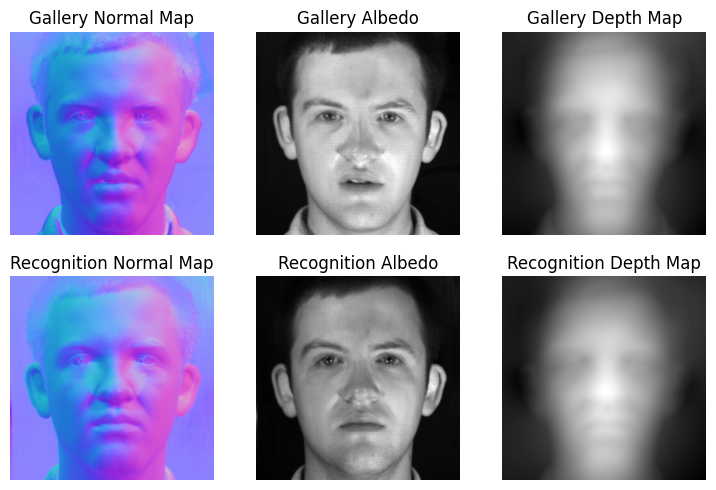

In [16]:
plt.figure(figsize=(9,9))

plt.subplot(3,3,1)
plt.imshow(gallery_normal)
plt.axis('off')
plt.title('Gallery Normal Map')

plt.subplot(3,3,2)
plt.imshow(gallery_albedo, cmap='gray')
plt.axis('off')
plt.title('Gallery Albedo')

plt.subplot(3,3,3)
plt.imshow(gallery_depthmap, cmap='gray')
plt.axis('off')
plt.title('Gallery Depth Map')

plt.subplot(3,3,4)
plt.imshow(recognition_normal)
plt.axis('off')
plt.title('Recognition Normal Map')

plt.subplot(3,3,5)
plt.imshow(recognition_albedo, cmap='gray')
plt.axis('off')
plt.title('Recognition Albedo')

plt.subplot(3,3,6)
plt.imshow(recognition_depthmap, cmap='gray')
plt.axis('off')
plt.title('Recognition Depth Map')

# plt.subplot(3,3,7)
# plt.imshow(error_normal)
# plt.axis('off')
# plt.title('Error Normal Map')

# plt.subplot(3,3,8)
# plt.imshow(error_albedo, cmap='gray')
# plt.axis('off')
# plt.title('Error Albedo')

# plt.subplot(3,3,9)
# plt.imshow(error_depthmap, cmap='gray')
# plt.axis('off')
# plt.title('Error Depth Map')

plt.show()